<a href="https://colab.research.google.com/github/pandyah5/aps360-project/blob/baseline/baseline/baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset 
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import string
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
WORKING_DIR = "/content/drive/MyDrive/Documents/Uni/School/FifthYear/APS360/aps360/baseline"
os.chdir(WORKING_DIR)
DATASET_PATH = "mask_dataset_processed"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
CLASSES = {"with_mask": 0,
           "without_mask": 1,
           "mask_weared_incorrect": 2}

In [ ]:
def get_data_loader(batch_size, sanity_check=False, num_workers=1):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    

    classes = list(CLASSES.keys())
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.Resize((128,128)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load gestures training data
    dataset = torchvision.datasets.ImageFolder(
      root=DATASET_PATH,
      transform=transform)
    
    # Get the list of indices to sample from
    relevant_indices = list(range(len(dataset)))
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.7)
    
    np.random.shuffle(relevant_indices)
    split_train = int(len(relevant_indices) * 0.7)
    split_test = int(len(relevant_indices) * 0.9)

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices, relevant_test_indices = \
        relevant_indices[:split_train], relevant_indices[split_train:split_test], relevant_indices[split_test:]
    
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=num_workers, sampler=train_sampler)
    
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=num_workers, sampler=val_sampler)
    
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=num_workers, sampler=test_sampler)
    
    return train_loader, val_loader, test_loader, classes

In [ ]:
class BaselineNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = "baseline_net"

        self.pool = nn.MaxPool2d(kernel_size=2,
                                 stride=2)

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=3,
                               padding="same")

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=12,
                               kernel_size=3,
                               padding="same")

        self.conv3 = nn.Conv2d(in_channels=12,
                               out_channels=24,
                               kernel_size=3,
                               padding="same")

        self.conv4 = nn.Conv2d(in_channels=24,
                               out_channels=48,
                               kernel_size=3,
                               padding="same")

        self.fc1 = nn.Linear(8 * 8 * 48, 2048)

        self.fc2 = nn.Linear(2048, 1024)

        self.fc3 = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 8 * 8 * 48)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x


In [ ]:
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch, path_prefix=""):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    if path_prefix != "" and not os.path.exists(path_prefix):
        os.makedirs(path_prefix)

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    
    return os.path.join(path_prefix, path)


def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification accuracy over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Get the index of the max log-probability
        pred = outputs.max(1, keepdim=True)[1] 

        # Check for correctness
        corr = pred.eq(labels.view_as(pred))

        total_acc += int(corr.sum().item())
        total_loss += loss.item()
        total_epoch += len(labels)

    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


###############################################################################
# Training Code

def train_net(net, 
              path_prefix="", 
              batch_size=64, 
              learning_rate=0.01, 
              num_epochs=30,
              num_workers=1,
              sanity_check=False,
              custom_get_data_loader=None,
              **kwargs):



    torch.manual_seed(1000)

    if custom_get_data_loader:
      train_loader, val_loader, test_loader, classes = custom_get_data_loader(
              batch_size, num_workers=num_workers, sanity_check=sanity_check)
    else:
      train_loader, val_loader, test_loader, classes = get_data_loader(
              batch_size, num_workers=num_workers, sanity_check=sanity_check)
    
    criterion = nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=learning_rate)

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data

            # Move the inputs and labels to gpu if possible
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # print(f"inputs: {inputs.size()}, , labels: {labels.size()}, outputs: {outputs.size()}")
            # print("---")
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            # Get the index of the max log-probability
            pred = outputs.max(1, keepdim=True)[1] 

            # Check for correctness
            corr = pred.eq(labels.view_as(pred))

            total_train_acc += int(corr.sum().item())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        train_acc[epoch] = float(total_train_acc) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch, path_prefix=path_prefix)
        torch.save(net.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/acc into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    return test_loader

In [ ]:
model = BaselineNet().to(device)
training_params = {
    "net": model,
    "path_prefix": "test_bs_256",
    "network_name": "baseline_net",
    "batch_size": 256,
    "learning_rate": 0.001,
    "num_epochs": 30,
    "num_workers": 2

}
test_loader = train_net(**training_params)

Epoch 1: Train acc: 0.7905263157894736, Train loss: 0.7391664683818817 |Validation acc: 0.7936117936117936, Validation loss: 0.549523115158081
Epoch 2: Train acc: 0.7905263157894736, Train loss: 0.5277763629953066 |Validation acc: 0.7936117936117936, Validation loss: 0.5442207977175713
Epoch 3: Train acc: 0.84, Train loss: 0.3819943740963936 |Validation acc: 0.9041769041769042, Validation loss: 0.33023781329393387
Epoch 4: Train acc: 0.9171929824561403, Train loss: 0.24443951342254877 |Validation acc: 0.9361179361179361, Validation loss: 0.1989535540342331
Epoch 5: Train acc: 0.9403508771929825, Train loss: 0.17080678356190523 |Validation acc: 0.9398034398034398, Validation loss: 0.2501477338373661
Epoch 6: Train acc: 0.9392982456140351, Train loss: 0.1824836606780688 |Validation acc: 0.9484029484029484, Validation loss: 0.1514578778296709
Epoch 7: Train acc: 0.9438596491228071, Train loss: 0.17147002120812735 |Validation acc: 0.941031941031941, Validation loss: 0.14928147848695517
Epo

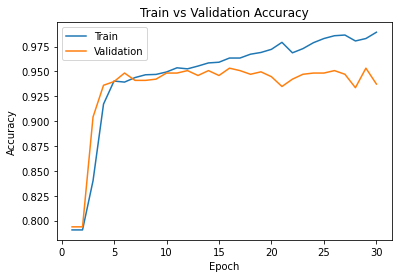

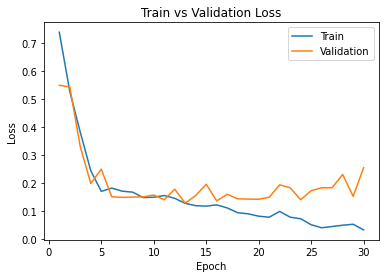

In [ ]:
model_path = get_model_name(training_params["network_name"], 
                            batch_size=training_params["batch_size"], 
                            learning_rate=training_params["learning_rate"], 
                            epoch=training_params["num_epochs"] - 1,
                            path_prefix=training_params["path_prefix"])

plot_training_curve(model_path)

In [ ]:
net = BaselineNet().to(device)

model_path = get_model_name(training_params["network_name"], 
                            batch_size=training_params["batch_size"], 
                            learning_rate=training_params["learning_rate"], 
                            epoch=26 - 1,
                            path_prefix=training_params["path_prefix"])
state = torch.load(model_path)
net.load_state_dict(state)
criterion = nn.CrossEntropyLoss()
err, loss=(evaluate(net, test_loader, criterion))
print("Test Accuracy: ", err)

Test Accuracy:  0.9436274509803921
